# Welcome

This notebook was originally created as an example for the geoopt package. I have extended this tutorial through implementing the hyperbolic linear layer using geoopt functions. This easily allows hyperbolic calculations to be integrated into an existing pytorch model. I also provide several useful functions for your own implementation of hyperbolic machine learning.

## Resources for learning differential geometry in machine learning 
I've found "Section 2: The Geometry of the Poincare Ball" from O. Ganea et.al's paper [Hyperbolic Neural Networks](https://arxiv.org/pdf/1805.09112.pdf) to be one of the best overviews of differential geometry in machine learning.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import sys
#Insert your path to the locally installed geoopt
sys.path.append('../geoopt')
import geoopt
import torch
import itertools
import torch.nn as nn
import torch.nn.init as init

import math
import numpy as np
import tqdm
%matplotlib inline
# import importlib
# importlib.reload(geoopt)

# Dataset

Code may be found complicated. Esssentally, I adopted it from Poincare VAE repository for demonstration purposes.

In [2]:
#@title
class SyntheticDataset(torch.utils.data.Dataset):
    '''
    Adopted from https://github.com/emilemathieu/pvae/blob/ca5c4997a90839fc8960ec812df4cbf83da55781/pvae/datasets/datasets.py
    
    Implementation of a synthetic dataset by hierarchical diffusion. 
    Args:
    :param int dim: dimension of the input sample
    :param int depth: depth of the tree; the root corresponds to the depth 0
    :param int :numberOfChildren: Number of children of each node in the tree
    :param int :numberOfsiblings: Number of noisy observations obtained from the nodes of the tree
    :param float sigma_children: noise
    :param int param: integer by which :math:`\\sigma_children` is divided at each deeper level of the tree
    '''
    def __init__(self, ball, dim, depth, numberOfChildren=2, dist_children=1, sigma_sibling=2, param=1, numberOfsiblings=1):
        assert numberOfChildren == 2
        self.dim = int(dim)
        self.ball = ball
        self.root = ball.origin(self.dim)
        self.sigma_sibling = sigma_sibling
        self.depth = int(depth)
        self.dist_children = dist_children
        self.numberOfChildren = int(numberOfChildren)
        self.numberOfsiblings = int(numberOfsiblings)  
        self.__class_counter = itertools.count()
        self.origin_data, self.origin_labels, self.data, self.labels = map(torch.detach, self.bst())
        self.num_classes = self.origin_labels.max().item()+1
        #self.data = ball.mobius_add(self.data, -ball.weighted_midpoint(self.data)).detach()

    def __len__(self):
        '''
        this method returns the total number of samples/nodes
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Generates one sample
        '''
        data, labels = self.data[idx], self.labels[idx]
        return data, labels, labels.max(-1).values

    def get_children(self, parent_value, parent_label, current_depth, offspring=True):
        '''
        :param 1d-array parent_value
        :param 1d-array parent_label
        :param int current_depth
        :param  Boolean offspring: if True the parent node gives birth to numberOfChildren nodes
                                    if False the parent node gives birth to numberOfsiblings noisy observations
        :return: list of 2-tuples containing the value and label of each child of a parent node
        :rtype: list of length numberOfChildren
        '''
        if offspring:
            numberOfChildren = self.numberOfChildren
            sigma = self.dist_children
        else:
            numberOfChildren = self.numberOfsiblings
            sigma = self.sigma_sibling
        if offspring:
            direction = torch.randn_like(parent_value)
            parent_value_n = parent_value / parent_value.norm().clamp_min(1e-15)
            direction -= parent_value_n @ direction * parent_value_n
            child_value_1 = ball.geodesic_unit(torch.tensor(sigma), parent_value, direction)
            child_value_2 = ball.geodesic_unit(torch.tensor(sigma), parent_value, -direction)
            child_label_1 = parent_label.clone()
            child_label_1[current_depth] = next(self.__class_counter)
            child_label_2 = parent_label.clone()
            child_label_2[current_depth] = next(self.__class_counter)
            children = [
                (child_value_1, child_label_1),
                (child_value_2, child_label_2)
            ]
        else:
            children = []
            for i in range (numberOfChildren):
                child_value = ball.random(self.dim, mean=parent_value, std=sigma ** .5)
                child_label = parent_label.clone()
                children.append((child_value, child_label))
        return children

    def bst(self):
        '''
        This method generates all the nodes of a level before going to the next level
        '''
        label = -torch.ones(self.depth+1, dtype=torch.long)
        label[0] = next(self.__class_counter)
        queue = [(self.root, label, 0)]
        visited = []
        labels_visited = []
        values_clones = []
        labels_clones = []
        while len(queue) > 0:
            current_node, current_label, current_depth = queue.pop(0)
            visited.append(current_node)
            labels_visited.append(current_label)
            if current_depth < self.depth:
                children = self.get_children(current_node, current_label, current_depth)
                for child in children:
                    queue.append((child[0], child[1], current_depth + 1)) 
            if current_depth <= self.depth:
                clones = self.get_children(current_node, current_label, current_depth, False)
                for clone in clones:
                    values_clones.append(clone[0])
                    labels_clones.append(clone[1])
        length = int(((self.numberOfChildren) ** (self.depth + 1) - 1) / (self.numberOfChildren - 1))
        length_leaves = int(self.numberOfChildren**self.depth)
        images = torch.cat([i for i in visited]).reshape(length, self.dim)
        labels_visited = torch.cat([i for i in labels_visited]).reshape(length, self.depth+1)[:,:self.depth]
        values_clones = torch.cat([i for i in values_clones]).reshape(self.numberOfsiblings*length, self.dim)
        labels_clones = torch.cat([i for i in labels_clones]).reshape(self.numberOfsiblings*length, self.depth+1)
        return images, labels_visited, values_clones, labels_clones

Let's go ahead and create our dataset and the manifold we will classify on. Our datset is a noisy tree where each node is a class. In total we have a 3 level binary tree with 100 examples per node

In [3]:
ball = geoopt.PoincareBall(c=0.6)
torch.manual_seed(42)
dataset = SyntheticDataset(ball, 2, 3, numberOfsiblings=100, sigma_sibling=0.02, dist_children=1)
num_classes = dataset.num_classes

In [4]:
dataset[0:20][0]

tensor([[ 0.0234,  0.0230],
        [-0.1120, -0.0186],
        [ 0.2185, -0.0631],
        [ 0.0461,  0.0267],
        [ 0.0534,  0.0808],
        [ 0.1101, -0.1676],
        [-0.0985,  0.0954],
        [ 0.1316,  0.0813],
        [-0.0764, -0.0749],
        [ 0.1346,  0.0683],
        [-0.0327,  0.0794],
        [ 0.0281,  0.0056],
        [ 0.0522, -0.0238],
        [-0.0050,  0.0526],
        [-0.0008,  0.0728],
        [ 0.0133,  0.0863],
        [-0.1012, -0.0886],
        [ 0.0150, -0.0209],
        [-0.0386,  0.0989],
        [ 0.0468, -0.0205]])

## Visualizing the data

In [5]:
#@title long util funtion to plot geodesic grid
def add_geodesic_grid(ax: plt.Axes, manifold: geoopt.Stereographic, line_width=0.1):

    # define geodesic grid parameters
    N_EVALS_PER_GEODESIC = 10000
    STYLE = "--"
    COLOR = "gray"
    LINE_WIDTH = line_width

    # get manifold properties
    K = manifold.k.item()
    R = manifold.radius.item()

    # get maximal numerical distance to origin on manifold
    if K < 0:
        # create point on R
        r = torch.tensor((R, 0.0), dtype=manifold.dtype)
        # project point on R into valid range (epsilon border)
        r = manifold.projx(r)
        # determine distance from origin
        max_dist_0 = manifold.dist0(r).item()
    else:
        max_dist_0 = np.pi * R
    # adjust line interval for spherical geometry
    circumference = 2*np.pi*R

    # determine reasonable number of geodesics
    # choose the grid interval size always as if we'd be in spherical
    # geometry, such that the grid interpolates smoothly and evenly
    # divides the sphere circumference
    n_geodesics_per_circumference = 4 * 6  # multiple of 4!
    n_geodesics_per_quadrant = n_geodesics_per_circumference // 2
    grid_interval_size = circumference / n_geodesics_per_circumference
    if K < 0:
        n_geodesics_per_quadrant = int(max_dist_0 / grid_interval_size)

    # create time evaluation array for geodesics
    if K < 0:
        min_t = -1.2*max_dist_0
    else:
        min_t = -circumference/2.0
    t = torch.linspace(min_t, -min_t, N_EVALS_PER_GEODESIC)[:, None]

    # define a function to plot the geodesics
    def plot_geodesic(gv):
        ax.plot(*gv.t().numpy(), STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # define geodesic directions
    u_x = torch.tensor((0.0, 1.0))
    u_y = torch.tensor((1.0, 0.0))

    # add origin x/y-crosshair
    o = torch.tensor((0.0, 0.0))
    if K < 0:
        x_geodesic = manifold.geodesic_unit(t, o, u_x)
        y_geodesic = manifold.geodesic_unit(t, o, u_y)
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
    else:
        # add the crosshair manually for the sproj of sphere
        # because the lines tend to get thicker if plotted
        # as done for K<0
        ax.axvline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)
        ax.axhline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # add geodesics per quadrant
    for i in range(1, n_geodesics_per_quadrant):
        i = torch.as_tensor(float(i))
        # determine start of geodesic on x/y-crosshair
        x = manifold.geodesic_unit(i*grid_interval_size, o, u_y)
        y = manifold.geodesic_unit(i*grid_interval_size, o, u_x)

        # compute point on geodesics
        x_geodesic = manifold.geodesic_unit(t, x, u_x)
        y_geodesic = manifold.geodesic_unit(t, y, u_y)

        # plot geodesics
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
        if K < 0:
            plot_geodesic(-x_geodesic)
            plot_geodesic(-y_geodesic)

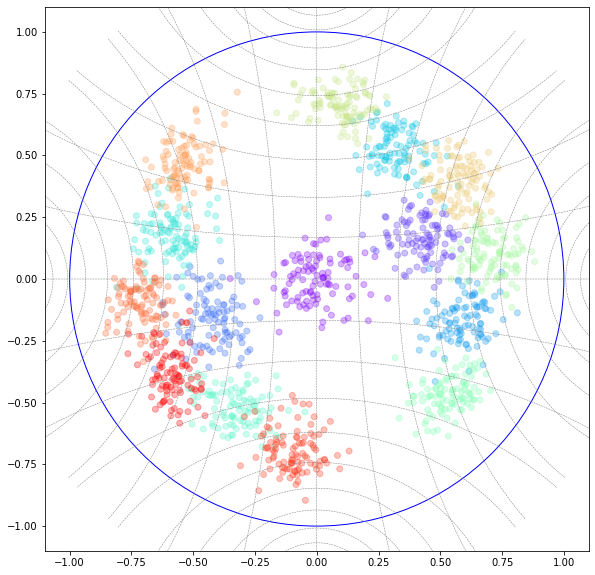

In [6]:
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
add_geodesic_grid(plt.gca(), ball, 0.5)
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.scatter(*dataset.data.T, 
            c=dataset.labels.max(-1).values.float() / num_classes, 
            alpha=.3, cmap="rainbow");

Probably the most interesting (engeneering) part of the notebook. Here I create a pytorch layer that works on manifold and has manifold parameters. Essentially? I've copied this code from `geoopt-layers` library which is not yet published (but will be soon).  

#  Hyperbolic NN Layers

In [7]:
class Distance2PoincareHyperplanes(torch.nn.Module):
    n = 1
    # 1D, 2D versions of this class ara available with a one line change
    # class Distance2PoincareHyperplanes2d(Distance2PoincareHyperplanes):
    #     n = 2

    def __init__(
        self,
        plane_shape: int,
        num_planes: int,
        signed=True,
        squared=False,
        *,
        ball,
        std=1.0,
    ):
        super().__init__()
        self.signed = signed
        self.squared = squared
        
        # Do not forget to save Manifold instance to the Module
        
        self.ball = ball
        self.plane_shape = geoopt.utils.size2shape(plane_shape)
        self.num_planes = num_planes

        # In a layer we create Manifold Parameters in the same way we do it for
        # regular pytorch Parameters, there is no difference. But geoopt optimizer
        # will recognize the manifold and adjust to it
        self.points = geoopt.ManifoldParameter(
            torch.empty(num_planes, plane_shape), manifold=self.ball
        )
        self.std = std
        # following best practives, a separate method to reset parameters
        self.reset_parameters()

    def forward(self, input):
        input_p = input.unsqueeze(-self.n - 1)
        points = self.points


        distance = self.ball.dist2plane(
            x=input_p, p=points, a=points, signed=self.signed, dim=-1
        )
        if self.squared and self.signed:
            sign = distance.sign()
            distance = distance ** 2 * sign
        elif self.squared:
            distance = distance ** 2
        return distance

    def extra_repr(self):
        return (
            "plane_shape={plane_shape}, "
            "num_planes={num_planes}, "
            .format(**self.__dict__)
        )

    @torch.no_grad()
    def reset_parameters(self):
        direction = torch.randn_like(self.points)
        direction /= direction.norm(dim=-1, keepdim=True)
        distance = torch.empty_like(self.points[..., 0]).normal_(std=self.std)
        self.points.set_(self.ball.expmap0(direction * distance.unsqueeze(-1)))


In [8]:
'''
We can implement the traditional Linear layer for hyperbolic space through modifying arithmetic operations for 
mobius gyrovectors
'''
class HypLinear(nn.Module):
    def __init__(self, in_features, out_features, ball, bias=True):
        super(HypLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ball = ball
        self.weight = geoopt.ManifoldParameter(torch.Tensor(out_features, in_features),manifold=self.ball)
        if bias:
            self.bias = geoopt.ManifoldParameter(torch.Tensor(out_features),manifold=self.ball)
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    '''
    Due to the exponential nature of hyperbolic space, it is beneficial to initialize with 
    relatively small weights (<1)
    '''
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(0.1))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x, c=None):

       
        mv = self.ball.mobius_matvec(self.weight, x)

        
        if not self.bias is None:
            bias = self.ball.expmap0(self.bias)
            mv = self.ball.mobius_add(mv, bias)
            
        return self.ball.projx(mv)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, c={}".format(
            self.in_features, self.out_features, self.bias is not None, self.ball
        )

For a classifier I will use features aquired from distances to 10 hyperplanes followed by a small MLP. That works satisfactory for the problem. Here you can see how our implementation of HypLinear can seemlessly integrate into a pytorch NN.

In [9]:
hyperbolic_classifier = torch.nn.Sequential(HypLinear(2, 2,ball=ball),
    Distance2PoincareHyperplanes(2, 10, ball=ball),
    HypLinear(10, 32,ball=ball),
    torch.nn.ReLU(),
    HypLinear(32, num_classes,ball=ball),
)

In [10]:
hyperbolic_classifier

Sequential(
  (0): HypLinear(
    in_features=2, out_features=2, bias=True, c=PoincareBall manifold
    (ball): PoincareBall manifold
  )
  (1): Distance2PoincareHyperplanes(
    plane_shape=(2,), num_planes=10, 
    (ball): PoincareBall manifold
  )
  (2): HypLinear(
    in_features=10, out_features=32, bias=True, c=PoincareBall manifold
    (ball): PoincareBall manifold
  )
  (3): ReLU()
  (4): HypLinear(
    in_features=32, out_features=15, bias=True, c=PoincareBall manifold
    (ball): PoincareBall manifold
  )
)

To optimize the model, you should use `geoopt.optim.RiemannianAdam`. No need to create 2 optimizers for Euclidean parameters, and manifold ones. Geoopt optimizers work uniformly for all regular and manifold tensors. If you use pytorch optimizer, it will not comply with the geometry of the manifold and constraints in implies.

In [11]:
optim = geoopt.optim.RiemannianAdam(hyperbolic_classifier.parameters(), lr=1e-2)

In [12]:
loader = torch.utils.data.DataLoader(dataset, 100, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()

Running the training loop will take about 40 seconds on colab CPU

In [199]:
with tqdm.trange(300) as _range:
    for epoch in _range:
        for p, _, l in loader:
            optim.zero_grad()
            logits = hyperbolic_classifier(p)
            loss = criterion(logits, l)
            loss.backward()
            optim.step()
            _range.set_description(f"loss={loss.item()}")

loss=1.1926896572113037: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:48<00:00,  6.21it/s]


/n/holystore01/LABS/iaifi_lab/Users/nswood/mambaforge/envs/flat-samples/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


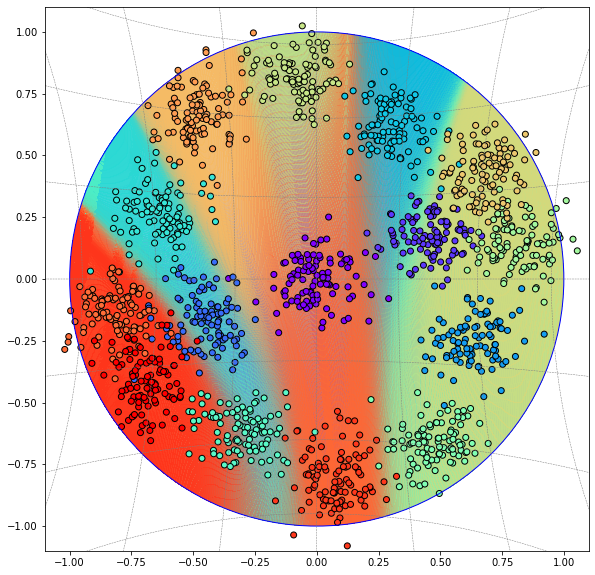

In [15]:
#@title Plotting the result
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
radius = 1.
coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 <= radius ** 2
grid = torch.stack([xx, yy], dim=-1)
probs = hyperbolic_classifier(grid.view(-1, 2)).reshape(*xx.shape, num_classes).softmax(-1)
probs[~mask] = np.nan

cmap = plt.get_cmap("rainbow")
for c in range(num_classes):
    base_color = cmap(c / num_classes)
    tmp_cmap = matplotlib.colors.LinearSegmentedColormap("tmp", dict(
        red=[[0, base_color[0], base_color[0]], [1, base_color[0], base_color[0]]],
        green=[[0, base_color[1], base_color[1]], [1, base_color[1], base_color[1]]],
        blue=[[0, base_color[2], base_color[2]], [1, base_color[2], base_color[2]]],
        alpha=[[0, 0, 0], [1, 1, 1]],
    ))
    plt.contourf(
        grid[..., 0], grid[..., 1], probs[..., c].detach().numpy(), levels=100, cmap=tmp_cmap
    )

add_geodesic_grid(plt.gca(), ball, 0.5)
plt.scatter(*dataset.data.T, c=dataset.labels.max(-1).values, cmap="rainbow", edgecolors='black');


You can do even more with geoopt. There is a lot of other useful manifolds:

**Manifolds:**

-  [``geoopt.Euclidean``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/euclidean.py) – unconstrained manifold in ``R`` with
   Euclidean metric
-  [``geoopt.Stiefel``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/stiefel.py) – Stiefel manifold on matrices
   ``A in R^{n x p} : A^t A=I``, ``n >= p``
-  [``geoopt.Sphere``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/sphere.py) - Sphere manifold ``||x||=1``
-  [``geoopt.BirkhoffPolytope``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/birkhoff_polytope.py) - manifold of Doubly Stochastic matrices
-  [``geoopt.Stereographic``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/stereographic/manifold.py#L90) - Constant curvature stereographic projection model
-  [``geoopt.SphereProjection``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/stereographic/manifold.py#L551) - Sphere stereographic projection model
-  [``geoopt.PoincareBall``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/stereographic/manifold.py#L505) - Poincare ball model 
-  [``geoopt.ProductManifold``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/product.py) - Product manifold constructor
-  [``geoopt.Scaled``](https://github.com/geoopt/geoopt/blob/master/geoopt/manifolds/scaled.py) - Scaled version of the manifold. Similar to `Learning Mixed-Curvature Representations in Product Spaces if combined with ``ProductManifold``

# Mapping Data from Euclidean to Hyperbolic Space
While the first example we looked at demonstrated how to create a machine learning model for hyperbolic data, often you will encounter data that is not explicity hyperbolic, but needs to be mapped into the hyperbolic space. This can be done through an [exponential mapping](https://en.wikipedia.org/wiki/Exponential_map_(Riemannian_geometry). 

In [100]:
euclidean_data = torch.rand(100,2)

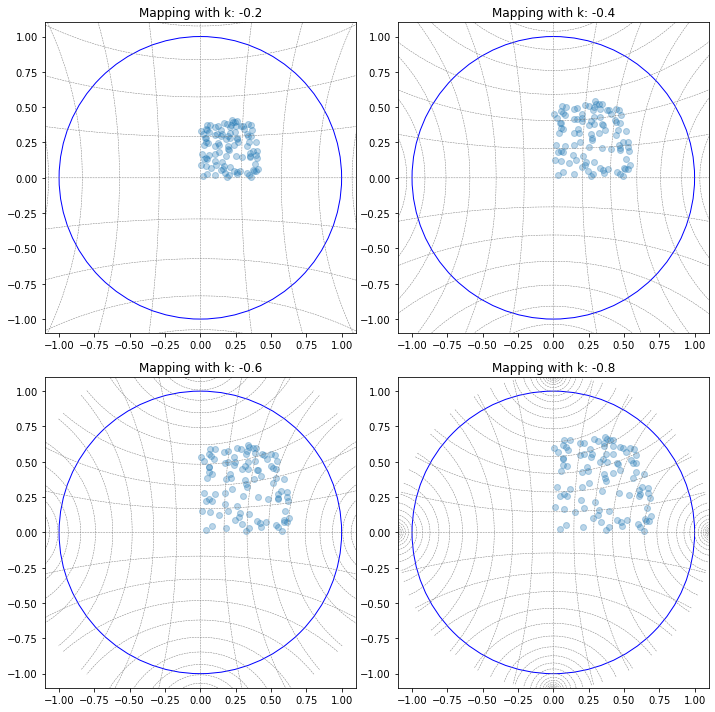

In [89]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot in each subplot
n = 0
for i in range(2):
    for j in range(2):
        n = n +1
        ball = geoopt.PoincareBall(c=0.2*(n))
        euclid_mapped = ball.expmap0(euclidean_data)
        factor = np.sqrt((-1 / ball.k))
        ax = axs[i, j]
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect("equal")
        circle = plt.Circle((0, 0), 1, fill=False, color="b")
        ax.add_artist(circle)
        # Assuming add_geodesic_grid is already defined elsewhere
        add_geodesic_grid(ax, ball, 0.5)
        ax.scatter(euclid_mapped[:, 0] / factor, euclid_mapped[:, 1] / factor, alpha=0.3)
        ax.set_title(f'Mapping with k: {np.round(ball.k.item(), 3)}')

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()


## Mapping to Euclidean Space within Models
It may be more convenient to utilize this mapping within a model. You can utilize the nn.Module below to integrate this mapping within your models.

In [97]:
print(euclidean_data[0])
print(ball.logmap0(ball.expmap0(euclidean_data[0])))

tensor([0.9203, 0.7294, 0.8137, 0.8230, 0.2105, 0.6443, 0.4373, 0.6745])
tensor([0.9203, 0.7294, 0.8137, 0.8230, 0.2105, 0.6443, 0.4373, 0.6745])


In [15]:
class E2H(nn.Module):
    def __init__(self,ball,project=True):
        super(E2H, self).__init__()
        self.ball = ball
        self.project = project
    def forward(self, x):
        return geoopt.tensor.ManifoldTensor(self.ball.expmap0(x,project = self.project),manifold = self.ball)


In [16]:
class H2E(nn.Module):
    def __init__(self,ball,project=True):
        super(E2H, self).__init__()
        self.ball = ball
        self.project = project
    def forward(self, x):
        return self.ball.logmap0(x,project = self.project)


# Possibly Useful Functions

### Hyperbolic Distance Calculations for Contrastive Losses
Below is an implementation of the simclr loss for hyperbolic data using geoopt. As a warning, I would consider if at the point of your loss calculation if you data should still be in hyperbolic space or in euclidean space. This will be key in optimizing your model's performance

In [17]:
'''
We can extend the Stereographic with this function to aid in calculating the SimCLR loss in hyperbolic spaces. 
'''
def dist_matrix(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    num_samples = x.shape[0]
    distances = torch.zeros(num_samples,y.shape[0])

    for i in range(num_samples):
        distances[i] = self.dist(x[i], y)

    return distances

In [23]:
class HypSimCLRLoss(nn.Module):
    """
    Credit original SimCLR loss implementation to Phil Harris
    Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07,c=0.2):
        super(HypSimCLRLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.ball = geoopt.PoincareBall(c=c)

    def forward2(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
#         print(features)
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        
        '''
        HYPERBOLIC MODIFICATION
        
        Here is the only part of the SimCLR Loss that is modified. We perform the distance calculation
        in hyperbolic space.
        '''
        anchor_dot_contrast = torch.div(
            self.ball.dist_matrix(anchor_feature, contrast_feature),
            self.temperature)
        
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        
        return loss
    
    def forward(self, x_i, x_j):
        #xdevice = x_i.get_device()
        xdevice = (torch.device('cuda') if x_i.is_cuda else torch.device('cpu'))
        batch_size = x_i.shape[0]
        z_i = F.normalize( x_i, dim=1 )
        z_j = F.normalize( x_j, dim=1 )
        z   = torch.cat( [z_i, z_j], dim=0 )
        similarity_matrix = F.cosine_similarity( z.unsqueeze(1), z.unsqueeze(0), dim=2 )
        sim_ij = torch.diag( similarity_matrix,  batch_size )
        sim_ji = torch.diag( similarity_matrix, -batch_size )
        positives = torch.cat( [sim_ij, sim_ji], dim=0 )
        nominator = torch.exp( positives / self.temperature )
        negatives_mask = ( ~torch.eye( 2*batch_size, 2*batch_size, dtype=bool ) ).float()
        negatives_mask = negatives_mask.to( xdevice )
        denominator = negatives_mask * torch.exp( similarity_matrix / self.temperature )
        loss_partial = -torch.log( nominator / torch.sum( denominator, dim=1 ) )
        loss = torch.sum( loss_partial )/( 2*batch_size )
        return loss  

### Poincare General Linear Unit for Hyperbolic Transformers
While many other researchers perfer to use euclidean tranformers and pass data into hyperbolic geometry as a final step, it certainly is possible to implement a fully hyperbolic transformer. If so, the PoincareGLU may be of use:

In [469]:
from scipy.special import beta
class PoincareGLU(nn.Module):
    def __init__(self, ball=None):
        super().__init__()
        self.ball = ball
        self.scale = nn.Parameter(torch.zeros(1))

    def forward(self, x, dim=-1):
        channels = x.size(dim)
        beta_n = beta(channels / 2, 1 / 2)
        beta_ni = beta(channels / 4, 1 / 2)
        xa, xb = (self.ball.logmap0(x, dim=dim) * beta_ni / beta_n).chunk(2, dim=dim)
        return self.ball.expmap0(xa * (xb * (channels ** 0.5) * self.scale.exp()).sigmoid(), dim=dim)

### More Advanced Linear Layer from Hyperbolic NN ++
I encourage you to read the paper if you are curious of their implementation

In [ ]:
class HypLinear(nn.Module):
    def __init__(self, in_dim, out_dim, out_split=1, bias=True, ball=None, gain=1.):
        super(HypLinear, self).__init__()
        gain = 3 ###
        self.ball = ball
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.out_split = out_split
        w= torch.empty(in_dim, out_dim).normal_( 
            mean=0, std=(2 * self.in_dim * self.out_dim / out_split) ** -0.5 * gain)
        self.weight_g = nn.Parameter(w.norm(dim=0))
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.empty(out_dim), requires_grad=bias)
        self.reset_parameters()
        self.beta_ni = beta(self.out_dim / out_split / 2, 1 / 2)
        self.beta_n = beta(self.out_dim / 2, 1 / 2)
    
    def reset_parameters(self):
        nn.init.zeros_(self.bias)
    
    def forward(self, x):
        x = poincare_linear(
            x, 
            self.weight_g, 
            self.weight / self.weight.norm(dim=0).clamp_min(1e-15), 
            self.bias, 
            self.ball.c,
            # out_split=self.out_split)
            out_split=1)
        if self.out_split > 1:
            size = x.size()
            x = self.ball.logmap0(x).contiguous().view(*size[:-1], self.out_split, size[-1] // self.out_split)
            x = self.ball.expmap0(x * self.beta_ni / self.beta_n)
        return x

    def extra_repr(self):
        return 'in_dim={}, out_dim={}, out_split={}, bias={}'.format(
            self.in_dim, self.out_dim, self.out_split, self.bias.requires_grad
        )
#@torch.jit.script
def poincare_linear(x, weight_g, weight_v, bias, c, out_split : int = 1):
    rc = c.sqrt()
    x = unidirectional_poincare_mlr(x, weight_g, weight_v, bias, c)
    x = (rc * x).sinh() / rc
    if out_split > 1:
        size = x.size()
        x = x.view(*size[:-1], out_split, size[-1] // out_split)

    return geoopt.manifolds.stereographic.math._project(x / (1 + (1 + c * x.pow(2).sum(dim=-1, keepdim=True)).sqrt()), -c, dim=-1)

@torch.jit.script
def unidirectional_poincare_mlr(x, z_norm, z_unit, r, c):
    # parameters
    rc = c.sqrt()
    drcr = 2. * rc * r

    # input
    rcx = rc * x
    cx2 = rcx.pow(2).sum(dim=-1, keepdim=True)

    return 2 * z_norm / rc * arsinh((2. * torch.matmul(rcx, z_unit) * drcr.cosh() - (1. + cx2) * drcr.sinh())/ torch.clamp_min(1. - cx2, 1e-15))